<a href="https://colab.research.google.com/github/UndiedPerson-V2/COVID-19-classification-of-X-ray-images/blob/main/Class_Activity_COVID_19_classification_of_X_ray_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download and Extract Dataset

### Subtask:
Download the 'Curated Chest X-Ray Image Dataset for COVID-19' from Kaggle, extract it, and prepare to focus on 'covid-19' and 'Normal' classes.

In [1]:
# 1. ติดตั้ง Library
!pip install -q kagglehub

import kagglehub

# 2. ดาวน์โหลดเวอร์ชันล่าสุด
path = kagglehub.dataset_download("unaissait/curated-chest-xray-image-dataset-for-covid19")

print("Path to dataset files:", path)

100%|██████████| 3.49G/3.49G [00:30<00:00, 122MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/unaissait/curated-chest-xray-image-dataset-for-covid19/versions/2


In [2]:
cd /root/.cache/kagglehub/datasets/unaissait/curated-chest-xray-image-dataset-for-covid19/versions/2/'Curated X-Ray Dataset'/

/root/.cache/kagglehub/datasets/unaissait/curated-chest-xray-image-dataset-for-covid19/versions/2/Curated X-Ray Dataset


In [3]:
ls

COVID-19/  Normal/  Pneumonia-Bacterial/  Pneumonia-Viral/


# Data Preprocessing

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define image dimensions and batch size
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 10

# Data directory
base_dir = os.getcwd()

# Collect all image paths and labels
image_paths = []
labels = []
classes = ['COVID-19', 'Normal']

for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)


In [5]:
# Create a DataFrame
df = pd.DataFrame({'filename': image_paths, 'class': labels})

# Split data into training, validation, and test sets (e.g., 70% train, 15% val, 15% test)
# First, split into train+validation and test
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['class'], random_state=42)

# Then, split train+validation into training and validation
train_df, val_df = train_test_split(train_val_df, test_size=(0.15/(1-0.15)), stratify=train_val_df['class'], random_state=42) # (0.15 of total) / (0.85 of total)

print(f"Total images: {len(df)}")
print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(val_df)}")
print(f"Test images: {len(test_df)}")

Total images: 4551
Training images: 3185
Validation images: 683
Test images: 683


In [6]:
# Data Preprocessing (rescaling only, no augmentation)
datagen = ImageDataGenerator(rescale=1./255)

# Create data generators from DataFrames
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    classes=classes
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=classes
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=classes
)


Found 3185 validated image filenames belonging to 2 classes.
Found 683 validated image filenames belonging to 2 classes.
Found 683 validated image filenames belonging to 2 classes.


# Create CNN Model

In [7]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 72s 615ms/step - accuracy: 0.8380 - loss: 0.3736 - val_accuracy: 0.9673 - val_loss: 0.0722
Epoch 2/10
 1/99 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 1.0000 - loss: 0.0505

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 1.0000 - loss: 0.0505 - val_accuracy: 0.9747 - val_loss: 0.0633
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 55s 555ms/step - accuracy: 0.9815 - loss: 0.0572 - val_accuracy: 0.9792 - val_loss: 0.0711
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 1.0000 - loss: 0.0323 - val_accuracy: 0.9747 - val_loss: 0.0802
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 53s 537ms/step - accuracy: 0.9855 - loss: 0.0460 - val_accuracy: 0.9792 - val_loss: 0.0530
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9688 - loss: 0.0557 - val_accuracy: 0.9807 - val_loss: 0.0499
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 52s 530ms/step - accuracy: 0.9878 - loss: 0.0352 - val_accuracy: 0.9807 - val_loss: 0.0373
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.9881 - val_loss: 0.0415
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 82s 832ms/step - accuracy: 0.9891 - loss: 0.0343 - val_accuracy: 0.9896 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.9688 - loss: 0.0243 - val_accuracy: 0.9896 - val_loss: 0.0430


# Evaluate CNN Model

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 512ms/step - accuracy: 0.9864 - loss: 0.0367
Test Loss: 0.0287
Test Accuracy: 0.9912


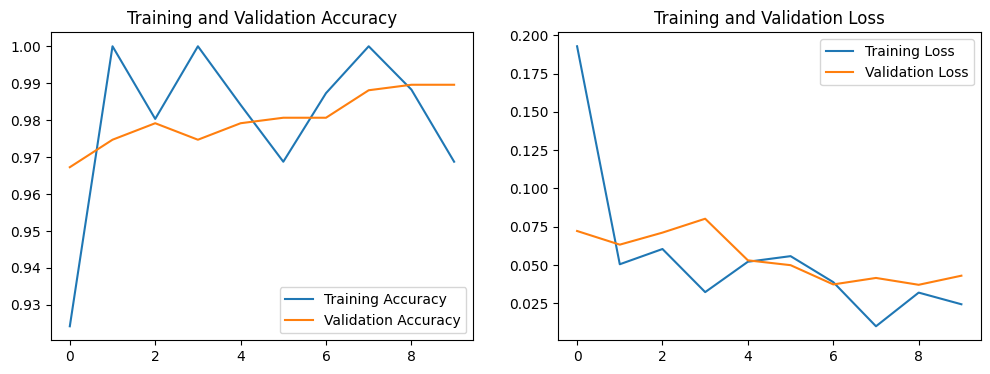

In [11]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 423ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    COVID-19       1.00      0.97      0.98       192
      Normal       0.99      1.00      0.99       491

    accuracy                           0.99       683
   macro avg       0.99      0.98      0.99       683
weighted avg       0.99      0.99      0.99       683


--- Confusion Matrix ---


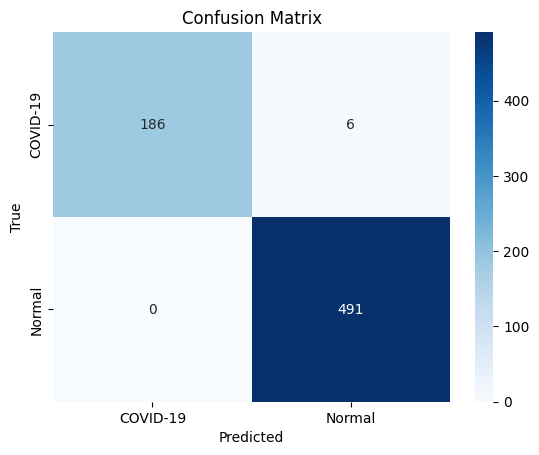

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the test set
test_steps = test_generator.samples // BATCH_SIZE + (1 if test_generator.samples % BATCH_SIZE > 0 else 0)
Y_pred = model.predict(test_generator, steps=test_steps)
y_pred_classes = np.round(Y_pred)

# Get true labels from the test generator
y_true = test_generator.labels

# Get class names from the generator
class_names = list(test_generator.class_indices.keys())

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Use Pre-trained Model

## Import MobileNetV2

### Subtask:
Import the MobileNetV2 model and related preprocessing functions from `tensorflow.keras.applications`.


**Reasoning**:
To complete the subtask, I need to import the `MobileNetV2` model and its associated `preprocess_input` function from `tensorflow.keras.applications.mobilenet_v2`.



In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

print("MobileNetV2 and preprocess_input imported successfully.")

MobileNetV2 and preprocess_input imported successfully.


## Load Pre-trained MobileNetV2 Base

### Subtask:
Load the MobileNetV2 model with ImageNet weights, excluding its top classification layer, and set it as non-trainable.


In [14]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

print("MobileNetV2 base model loaded and frozen successfully with updated input shape.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 base model loaded and frozen successfully with updated input shape.


## Add Custom Classification Head

### Subtask:
Add new layers on top of the MobileNetV2 base suitable for binary classification (GlobalAveragePooling2D, Dense, Dropout, and a final Dense layer with sigmoid activation).


In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Add custom classification head on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) # Added a Dense layer with 256 units
predictions = Dense(1, activation='sigmoid')(x) # Final output layer for binary classification

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

print("Custom classification head added and new model created successfully.")

Custom classification head added and new model created successfully.


In [16]:
model.summary()
print("Model compiled successfully and summary displayed.")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model compiled successfully and summary displayed.


## Train the New Model (Head Only)

### Subtask:
Train the model, initially only training the newly added classification head layers while keeping the MobileNetV2 base frozen.


In [17]:
datagen = ImageDataGenerator(rescale=1./255)

# Create data generators from DataFrames
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    classes=classes
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=classes
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=classes
)


Found 3185 validated image filenames belonging to 2 classes.
Found 683 validated image filenames belonging to 2 classes.
Found 683 validated image filenames belonging to 2 classes.


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("Model re-defined, recompiled, and training completed successfully.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9492 - loss: 0.1382

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 92s 742ms/step - accuracy: 0.9494 - loss: 0.1377 - val_accuracy: 0.9911 - val_loss: 0.0267
Epoch 2/10
 1/99 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9688 - loss: 0.1769

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.9688 - loss: 0.1769 - val_accuracy: 0.9911 - val_loss: 0.0265
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 53s 537ms/step - accuracy: 0.9859 - loss: 0.0365 - val_accuracy: 0.9866 - val_loss: 0.0320
Epoch 4/10
 1/99 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9412 - loss: 0.0846

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9412 - loss: 0.0846 - val_accuracy: 0.9851 - val_loss: 0.0351
Epoch 5/10
34/99 ━━━━━━━━━━━━━━━━━━━━ 29s 448ms/step - accuracy: 0.9908 - loss: 0.0254

In [ ]:
# Evaluate the pre-trained model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nPre-trained Model - Test Loss: {test_loss:.4f}")
print(f"Pre-trained Model - Test Accuracy: {test_accuracy:.4f}")

# Get predictions on the test set
test_steps = test_generator.samples // BATCH_SIZE + (1 if test_generator.samples % BATCH_SIZE > 0 else 0)
Y_pred = model.predict(test_generator, steps=test_steps)
y_pred_classes = (Y_pred > 0.5).astype(int) # Convert probabilities to binary classes

# Get true labels from the test generator
y_true = test_generator.labels

# Get class names from the generator
class_names = list(test_generator.class_indices.keys())

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Pre-trained Model - Classification Report ---")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

print("\n--- Pre-trained Model - Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Pre-trained Model - Confusion Matrix')
plt.show()

# Plot training history (re-run as the model was re-trained)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Pre-trained Model - Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Pre-trained Model - Training and Validation Loss')
plt.show()